In [1]:
# 1. Imports & Paths
import importlib.util

import os, sys, re, pandas as pd
sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data")
resume_path = os.path.join(DATA_DIR, "resumes_cleaned.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_cleaned.csv")
SAVE_DIR = os.path.join(os.pardir, "data/clusters")

EMB_DIR = os.path.join(os.pardir, "data/embeddings")
remb_path = os.path.join(EMB_DIR, "resume_embeddings.npy")
jemb_path   = os.path.join(EMB_DIR, "job_embeddings.npy")

In [2]:
%load_ext autoreload
%autoreload 2
from utils import *


c:\Users\adity\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 2484 resumes and 384-D embeddings.


100%|██████████| 12/12 [00:01<00:00,  8.58it/s]


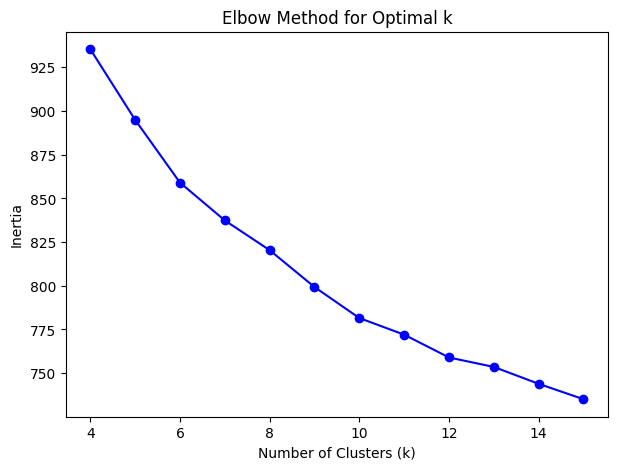

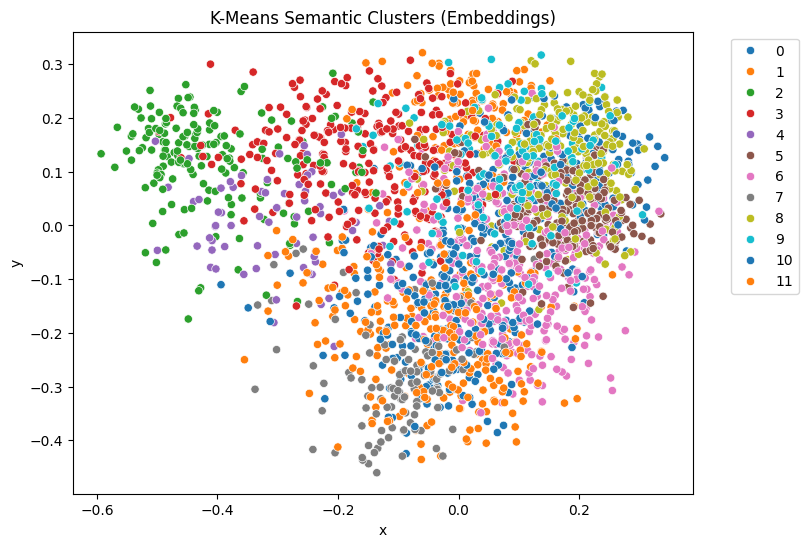

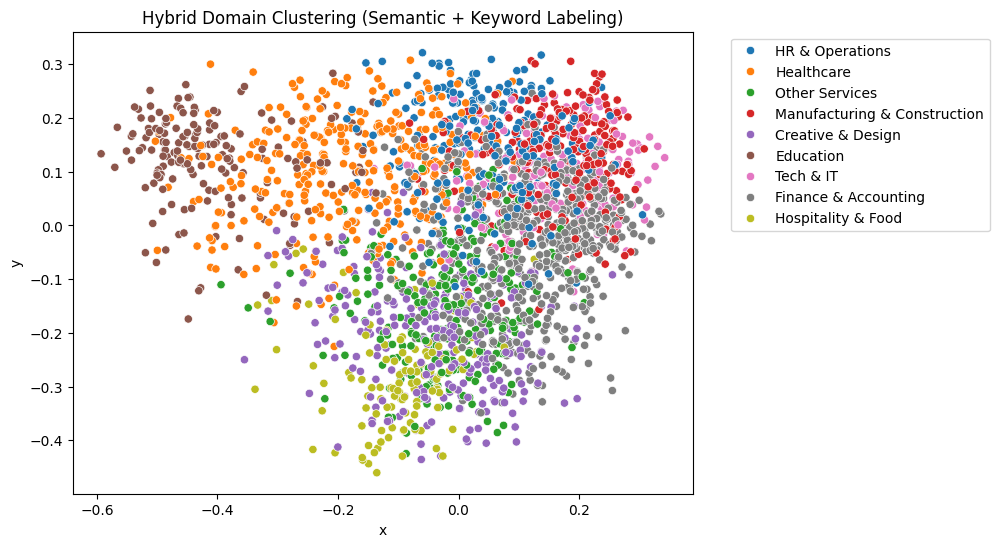

Adjusted Rand Index (vs true Domain): 0.241
Silhouette Score: 0.092
    PredictedCluster            ClusterDomainLabel  Count
6                  6          Finance & Accounting    389
3                  3                    Healthcare    275
10                10                Other Services    273
1                  1             Creative & Design    268
8                  8  Manufacturing & Construction    252
0                  0                     Tech & IT    213
5                  5          Finance & Accounting    205
2                  2                     Education    174
11                11               HR & Operations    137
9                  9               HR & Operations    117
7                  7            Hospitality & Food    115
4                  4                    Healthcare     66
✅ Saved clustered results to ..\data/clusters\resumes_clustered.csv


In [4]:
# 6clustering.ipynb — Hybrid Domain Clustering Notebook


# =============================================
# 2️⃣ Libraries for Clustering & Visualization
# =============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

# =============================================
# 3️⃣ Load Cleaned Data and Embeddings
# =============================================
resumes = pd.read_csv(resume_path)
jobs = pd.read_csv(jobs_path)
resume_embeddings = np.load(remb_path)
job_embeddings = np.load(jemb_path)

resumes = attach_domain_labels(resumes)
print(f"Loaded {len(resumes)} resumes and {resume_embeddings.shape[1]}-D embeddings.")

# =============================================
# 4️⃣ K-Means Semantic Clustering (Elbow Optimization)
# =============================================
from tqdm import tqdm
inertias = []
K = range(4, 16)
for k in tqdm(K):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(resume_embeddings)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose best cluster count (based on elbow)
n_clusters = 12
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
resumes['PredictedCluster'] = kmeans.fit_predict(resume_embeddings)

# =============================================
# 5️⃣ Dimensionality Reduction for Visualization
# =============================================
pca = PCA(n_components=2)
reduced = pca.fit_transform(resume_embeddings)
resumes['x'], resumes['y'] = reduced[:,0], reduced[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='PredictedCluster', data=resumes, palette='tab10')
plt.title('K-Means Semantic Clusters (Embeddings)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# =============================================
# 6️⃣ Keyword-Based Domain Labeling for Interpretation
# =============================================
def infer_keyword_domain(text, keywords_dict):
    text = str(text).lower()
    scores = {domain: sum(kw in text for kw in kws) for domain, kws in keywords_dict.items()}
    return max(scores, key=scores.get) if scores else 'Unknown'

resumes['KeywordDomain'] = resumes['Resume_clean'].apply(lambda t: infer_keyword_domain(t, DOMAIN_KEYWORDS_REFERENCE))

# Assign dominant keyword label per cluster
cluster_labels = {}
for cid, group in resumes.groupby('PredictedCluster'):
    top_label = group['KeywordDomain'].value_counts().idxmax()
    cluster_labels[cid] = top_label
resumes['ClusterDomainLabel'] = resumes['PredictedCluster'].map(cluster_labels)

# =============================================
# 7️⃣ Visualization with Keyword Labels
# =============================================
plt.figure(figsize=(8,6))
sns.scatterplot(x='x', y='y', hue='ClusterDomainLabel', data=resumes, palette='tab10')
plt.title('Hybrid Domain Clustering (Semantic + Keyword Labeling)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# =============================================
# 8️⃣ Evaluation Metrics
# =============================================
ari = adjusted_rand_score(resumes['DomainCluster'], resumes['PredictedCluster'])
sil = silhouette_score(resume_embeddings, resumes['PredictedCluster'])
print(f'Adjusted Rand Index (vs true Domain): {ari:.3f}')
print(f'Silhouette Score: {sil:.3f}')

# =============================================
# 9️⃣ Cluster Summary
# =============================================
summary = resumes.groupby(['PredictedCluster', 'ClusterDomainLabel']).size().reset_index(name='Count')
print(summary.sort_values('Count', ascending=False))

# Save output
out_path = os.path.join(SAVE_DIR, 'resumes_clustered.csv')
resumes.to_csv(out_path, index=False)
print(f'✅ Saved clustered results to {out_path}')